In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product

ip_map = {
    "45.77.229.242": "GB-London",
    "62.154.179.86": "DE-Berlin",
    "194.156.155.241": "ES-Madrid",
    "194.230.35.117": "CH-Zurich",
    "193.46.104.12": "AT-Vienna", #should be .17 but error
    "185.32.189.249": "PT-Lisbon",
    "213.135.49.134": "PL-Warsaw",
    "51.159.68.135": "FR-Paris",
    "185.78.84.3": "TR-Istanbul",
    "185.157.208.248": "GR-Athens"
}

In [3]:
import geopandas as gpd

cities = {
    "GB-London": (-0.0695, 51.5185),
    "DE-Berlin": (13.4205, 52.5495),
    "ES-Madrid": (-3.6215, 40.4405),
    "CH-Zurich": (8.5605, 47.4185),
    "AT-Vienna": (16.4075, 48.2715),
    "PT-Lisbon": (-9.1215, 38.7915),
    "PL-Warsaw": (20.9375, 52.2515),
    "FR-Paris": (2.4075, 48.7905),
    "TR-Istanbul": (28.8305, 40.9915),
    "GR-Athens": (23.7705, 38.0695)
}

df = pd.DataFrame([
    {"city": name, "lon": coord[0], "lat": coord[1]}
    for name, coord in cities.items()
])

gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['lon'], df['lat']),
    crs="EPSG:4326"
)

gdf = gdf.to_crs("EPSG:3857")

dist_rows = []
for src_city, dst_city in product(gdf['city'], repeat=2):
    src_geom = gdf[gdf['city'] == src_city].geometry.values[0]
    dst_geom = gdf[gdf['city'] == dst_city].geometry.values[0]
    
    dist_km = src_geom.distance(dst_geom) / 1000
    
    dist_rows.append({
        "src": src_city,
        "dst": dst_city,
        "distance_km": dist_km
    })
dist_df = pd.DataFrame(dist_rows)


In [4]:
ping_df = pd.read_csv("data/full/ping.csv")

ping_df['src'] = ping_df['src_addr'].map(ip_map)
ping_df['dst'] = ping_df['dst_addr'].map(ip_map)

ping_df['timestamp'] = pd.to_datetime(ping_df['timestamp'], unit='s')
ping_df = ping_df.sort_values('timestamp')

ping_df['pair'] = ping_df['src'] + " - " + ping_df['dst']

print(ping_df)


             dst_addr         src_addr proto  rcvd  sent        min  \
26208  194.230.35.117   213.135.49.134  ICMP     3     3  26.390596   
26207  194.230.35.117    51.159.68.135  ICMP     3     3  17.726252   
26210  194.230.35.117  185.157.208.248  ICMP     3     3  41.533386   
38303  213.135.49.134  185.157.208.248  ICMP     3     3  38.977013   
26209  194.230.35.117      185.78.84.3  ICMP     3     3  48.615360   
...               ...              ...   ...   ...   ...        ...   
74583   45.77.229.242  194.156.155.241  ICMP     3     3  25.909513   
74582   45.77.229.242    51.159.68.135  ICMP     3     3   9.569730   
74587   45.77.229.242      185.78.84.3  ICMP     3     3  44.291965   
74581   45.77.229.242   185.32.189.249  ICMP     3     3  29.492512   
36284  194.230.35.117   185.32.189.249  ICMP     3     3  44.601833   

             max        avg     msm_id           timestamp  prb_id  \
26208  26.545200  26.456732  136909075 2025-11-10 00:00:13    7318   
26207  

In [5]:
ping_errors_df = ping_df[ping_df['avg'] <= 0.0]
ping_good_df   = ping_df[ping_df['avg'] > 0.0]

ping_good_swapped = ping_good_df.rename(columns={'src_addr':'dst_addr', 'dst_addr':'src_addr', 'src':'dst', 'dst':'src'})
ping_good_symmetric = pd.concat([ping_good_df, ping_good_swapped], ignore_index=True)

ping_errors_swapped = ping_errors_df.rename(columns={'src_addr':'dst_addr', 'dst_addr':'src_addr', 'src':'dst', 'dst':'src'})
ping_errors_symmetric = pd.concat([ping_errors_df, ping_errors_swapped], ignore_index=True)

agg_ping_good = ping_good_symmetric.groupby(['src', 'dst'])['avg'].mean().reset_index()
agg_ping_errors = ping_errors_symmetric.groupby(['src', 'dst'])['avg'].count().reset_index()

all_names = sorted([x for x in ip_map.values()])
full_pairs = pd.DataFrame(list(product(all_names, all_names)), columns=['src', 'dst'])
full_pairs = full_pairs.merge(dist_df, on=['src', 'dst'], how='left')

merged_good = full_pairs.merge(agg_ping_good, on=['src','dst'], how='left')
merged_good['ping_per_km'] = merged_good['avg'] / merged_good['distance_km'] * 1000
merged_good = merged_good.fillna(0).pivot(index='src', columns='dst', values='ping_per_km')

ping_good_heatmap_data = pd.merge(full_pairs, agg_ping_good, on=['src', 'dst'], how='left').fillna(0).pivot(index='src', columns='dst', values='avg')
ping_errors_heatmap_data = pd.merge(full_pairs, agg_ping_errors, on=['src', 'dst'], how='left').fillna(0).pivot(index='src', columns='dst', values='avg')


Text(70.72222222222221, 0.5, 'Source Address')

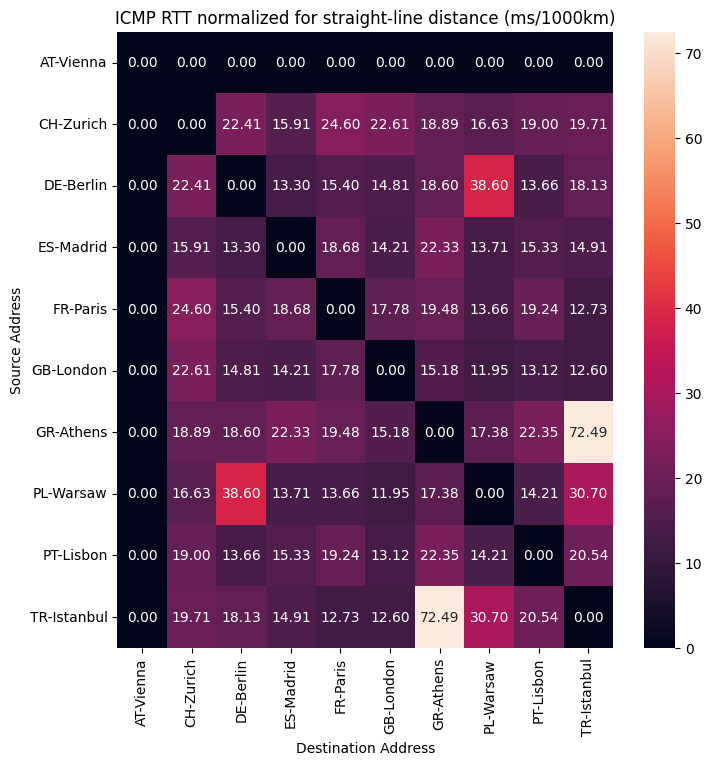

In [6]:
plt.figure(figsize=(8,8))
sns.heatmap(merged_good, annot=True, fmt="0.2f", cmap="rocket")
plt.title("ICMP RTT normalized for straight-line distance (ms/1000km)")
plt.xlabel("Destination Address")
plt.ylabel("Source Address")

Text(70.72222222222221, 0.5, 'Source Address')

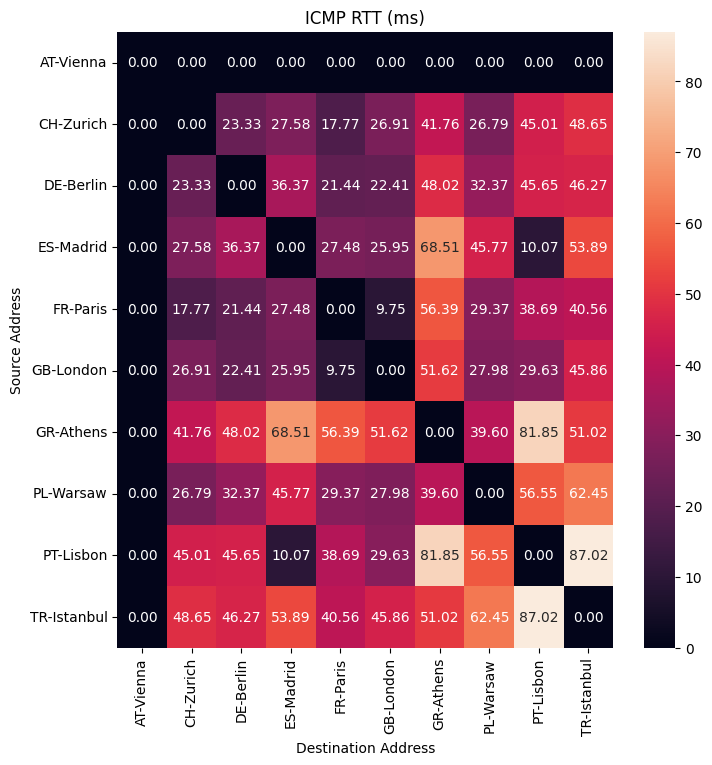

In [7]:
plt.figure(figsize=(8,8))
sns.heatmap(ping_good_heatmap_data, annot=True, fmt="0.2f", cmap="rocket")
plt.title("ICMP RTT (ms)")
plt.xlabel("Destination Address")
plt.ylabel("Source Address")

Text(70.72222222222221, 0.5, 'Source Address')

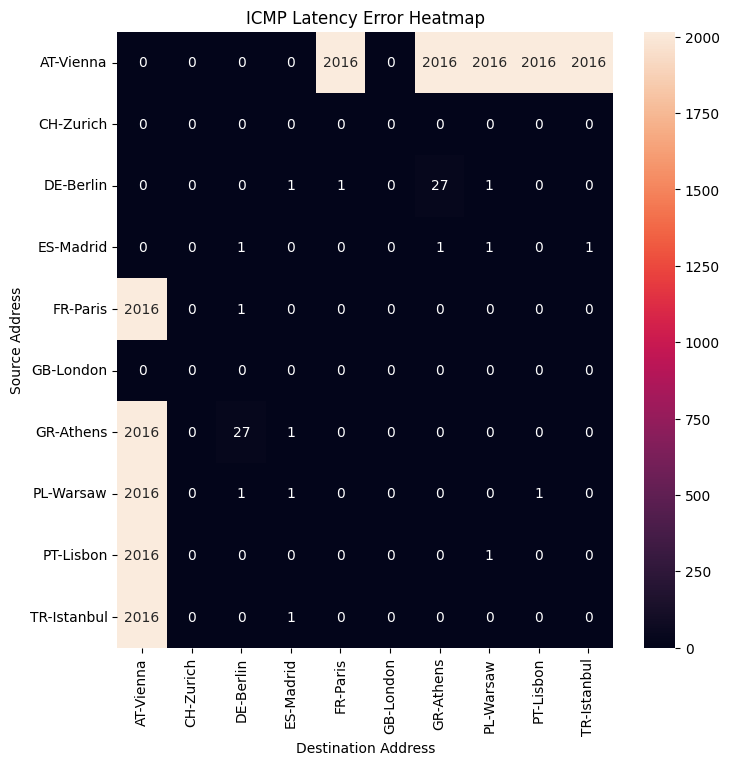

In [8]:
plt.figure(figsize=(8,8))
sns.heatmap(ping_errors_heatmap_data, fmt="0.0f", annot=True, cmap="rocket")
plt.title("ICMP Latency Error Heatmap")
plt.xlabel("Destination Address")
plt.ylabel("Source Address")